# Clustering Neighborhoods of Toronto using k means algorithm

#### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
from opencage.geocoder import OpenCageGeocode
from IPython.display import Image

#### Reading the data from the webpage

In [2]:
table = pd.read_html("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050")

#### Loading the data into a pandas dataframe.

In [3]:
df = pd.DataFrame(data = table[0])
df.head()

,0,1,2
0,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


#### Data Cleaning

Data Cleaning 1: Cleaning the structure of the dataframe

In [4]:
df.columns

Int64Index([0, 1, 2], dtype='int64')

In [5]:
df.iloc[0]

0         Postcode
1          Borough
2    Neighbourhood
Name: 0, dtype: object

In [6]:
df = df.rename(df.iloc[0], axis = 1)

In [7]:
df = df.drop(index=[0])

In [8]:
df.head()

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [9]:
length = len(df.Neighbourhood.tolist())
print(length)

287


Data Cleaning 2:
If a cell has a borough but an unassigned neighbourhood, we are assigning the neighbourhood same as borough.

In [10]:
for i in range(length):
#     print(df.Neighbourhood.iloc[i])
    if(df.Borough.iloc[i]!='Not assigned' and df.Neighbourhood.iloc[i]=='Not assigned'):
        df.Neighbourhood.iloc[i]=df.Borough.iloc[i]

Data cleaning 3:
Dropping the rows where borough is not assigned

In [11]:
clean_filter = df.Borough.str.contains('Not assigned')
df = df.replace(df[clean_filter], np.nan)

In [12]:
df = df.dropna(axis=0, how='all')

In [13]:
df.head()

,Postcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor


Grouping the neighbourhoods based on the postcode

In [14]:
group_by_postcode = df.groupby(df['Postcode'])
group_by_postcode.get_group('M5A')['Postcode']

5    M5A
Name: Postcode, dtype: object

Grouping the neighbourhoods having same postcode

In [15]:
df2 = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

Verifying grouping of neighourhoods

In [16]:
df2.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Storing Toronto Neighbourhood data in a separate dataframe.

Identifying Toronto neighbourhoods based on Borough containing the word 'Toronto'

In [17]:
neighbourhoods_in_toronto_df = df[df.Borough.str.contains('Toronto')]
neighbourhoods_in_toronto_df

,Postcode,Borough,Neighbourhood
5,M5A,Downtown Toronto,Harbourfront
8,M7A,Downtown Toronto,Queen's Park
17,M5B,Downtown Toronto,Ryerson
18,M5B,Downtown Toronto,Garden District
34,M5C,Downtown Toronto,St. James Town
47,M4E,East Toronto,The Beaches
48,M5E,Downtown Toronto,Berczy Park
57,M5G,Downtown Toronto,Central Bay Street
58,M6G,Downtown Toronto,Christie
68,M5H,Downtown Toronto,Adelaide


Fetching coordinates of each neighbourhood

In [18]:
latitude_list = []
longitude_list = []
geolocator = OpenCageGeocode('bb95973510e44e33a1ce4c61cd204612')
for neighb in neighbourhoods_in_toronto_df.Neighbourhood:
    address = neighb+', Toronto, Ontario'
    location = geolocator.geocode(address)
    latitude_list.append(location[0]['geometry']['lat'])
    longitude_list.append(location[0]['geometry']['lng'])
    #print(location[0]['geometry']['lat'], location[0]['geometry']['lng'])
print(latitude_list, longitude_list)

[43.6400801, 43.659659, 43.6584694, 43.6564995, 43.6694032, 43.6710244, 43.6479844, 43.6604829, 43.6641106, 43.6508233, 43.6489494, 43.8125891, 43.6653069, 43.6602019, 43.6400801, 43.6230544, 43.6446934, 43.6474132, 43.6653016, 43.6864333, 43.6654704, 43.6477412, 43.6473768, 43.6509173, 43.6334692, 43.6404954, 43.6710244, 43.6722231, 43.6481638, 43.6694691, 43.6444029, 43.729199, 43.7069805, 43.697936, 43.6935586, 43.701028, 43.6538668, 43.6654775, 43.6465466, 43.6703377, 43.7051999, 43.6713861, 43.6404954, 43.6514426, 43.697936, 43.6615122, 43.663462, 43.6517026, 43.64494, 43.6903876, 43.6816776, 43.6529237, 43.6521966, 43.6552136, 43.68809, 43.6935586, 43.6774724, 43.6779261, 43.6816776, 43.6425637, 43.6357905, 43.70011, 43.6400801, 43.6454561, 43.70011, 43.6418883, 43.6783556, 43.70011, 43.6644734, 43.6694032, 43.6487681, 43.7701454, 43.6655242, 43.70011] [-79.3801495, -79.3903399, -79.3789933, -79.3771141, -79.3727041, -79.296712, -79.3753959, -79.3836021, -79.4184051, -79.3779358,

Inserting the coordinates of neighbourhoods in our dataframe.

In [19]:
neighbourhoods_in_toronto_df.insert(loc=3, column='Latitude', value = latitude_list)
neighbourhoods_in_toronto_df.insert(loc=3, column='Longitude', value = longitude_list)
neighbourhoods_in_toronto_df = neighbourhoods_in_toronto_df.reset_index()
neighbourhoods_in_toronto_df = neighbourhoods_in_toronto_df.drop(['index'], axis = 1)

In [20]:
neighbourhoods_in_toronto_df.head()

,Postcode,Borough,Neighbourhood,Longitude,Latitude
0,M5A,Downtown Toronto,Harbourfront,-79.380150,43.640080
1,M7A,Downtown Toronto,Queen's Park,-79.390340,43.659659
2,M5B,Downtown Toronto,Ryerson,-79.378993,43.658469
3,M5B,Downtown Toronto,Garden District,-79.377114,43.656500
4,M5C,Downtown Toronto,St. James Town,-79.372704,43.669403


#### Plotting the Toronto neighbourhoods on the map.

In [21]:
toronto_location = geolocator.geocode('Toronto, Ontario, Canada')
toronto_location_lat = toronto_location[0]['geometry']['lat']
toronto_location_long = toronto_location[0]['geometry']['lng']
toronto_neighbourhood_map = folium.Map(location=[toronto_location_lat, toronto_location_long], zoom_start=10)

for lat, long, neighbourhood, borough in zip(neighbourhoods_in_toronto_df.Latitude, neighbourhoods_in_toronto_df.Longitude, neighbourhoods_in_toronto_df.Neighbourhood, neighbourhoods_in_toronto_df.Borough):
    label = '{}, {}'.format(neighbourhood, borough)
    #print(label, [lat, long])
    folium.CircleMarker(
    location = [lat, long],
    radius = 5,
    popup = label,
    fill = True,
    color = 'blue',
    fill_color = 'blue',
    fill_opacity = 1).add_to(toronto_neighbourhood_map)
toronto_neighbourhood_map

Displaying screenshot of the map, as Map might not be displayed on GitHub

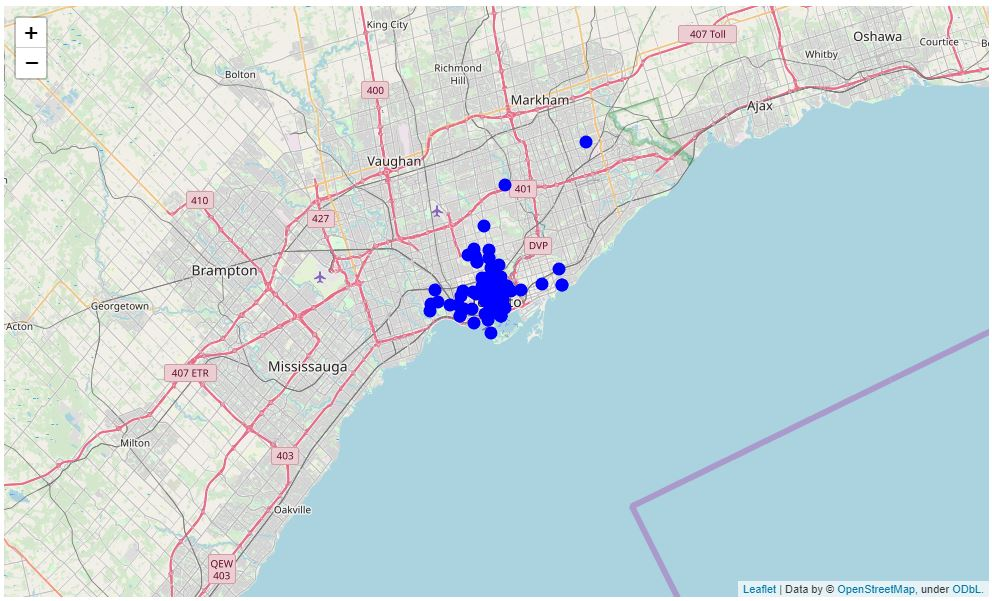

In [22]:
Image(filename='C:/Users/akash/Desktop/GitUpdate/Toronto_neighbourhoods.jpg')

In [23]:
print(neighbourhoods_in_toronto_df.Borough.unique().tolist(), len(neighbourhoods_in_toronto_df.Borough.unique().tolist()))

['Downtown Toronto', 'East Toronto', 'West Toronto', 'Central Toronto'] 4


#### Clustering the neighbourhoods using Kmeans.

In [24]:
k = len(neighbourhoods_in_toronto_df.Borough.unique().tolist())
k_means = KMeans(n_clusters=k).fit(neighbourhoods_in_toronto_df[['Latitude', 'Longitude']])

In [25]:
lbl = k_means.labels_
print(lbl)
from collections import Counter
print(Counter(lbl))

[2 2 2 2 2 1 2 2 0 2 2 1 0 0 2 2 2 0 2 1 2 2 2 0 0 0 1 1 2 2 2 3 3 3 3 3 0
 0 0 3 3 2 0 0 3 0 2 0 0 3 3 2 2 2 3 3 3 3 3 2 2 3 2 2 3 2 2 3 2 2 2 3 2 3]
Counter({2: 34, 3: 20, 0: 15, 1: 5})


Inserting cluster value against respective neighbourhoods

In [26]:
neighbourhoods_in_toronto_df['Cluster'] = lbl
neighbourhoods_in_toronto_df

,Postcode,Borough,Neighbourhood,Longitude,Latitude,Cluster
0,M5A,Downtown Toronto,Harbourfront,-79.380150,43.640080,2
1,M7A,Downtown Toronto,Queen's Park,-79.390340,43.659659,2
2,M5B,Downtown Toronto,Ryerson,-79.378993,43.658469,2
3,M5B,Downtown Toronto,Garden District,-79.377114,43.656500,2
4,M5C,Downtown Toronto,St. James Town,-79.372704,43.669403,2
5,M4E,East Toronto,The Beaches,-79.296712,43.671024,1
6,M5E,Downtown Toronto,Berczy Park,-79.375396,43.647984,2
7,M5G,Downtown Toronto,Central Bay Street,-79.383602,43.660483,2
8,M6G,Downtown Toronto,Christie,-79.418405,43.664111,0
9,M5H,Downtown Toronto,Adelaide,-79.377936,43.650823,2


#### Plotting clustered neighbourhoods

In [27]:
clustered_neighbourhood_map = folium.Map(location=[toronto_location_lat, toronto_location_long], zoom_start=10)

colors = {0: 'red', 1:'blue', 2:'green', 3:'grey'}
for lat, long, neighbourhood, cluster in zip(neighbourhoods_in_toronto_df.Latitude, neighbourhoods_in_toronto_df.Longitude, neighbourhoods_in_toronto_df.Neighbourhood, neighbourhoods_in_toronto_df.Cluster):
    label = '{}, {}'.format(neighbourhood, cluster)
    #print(label, [lat, long])
    folium.CircleMarker(
    location = [lat, long],
    radius = 5,
    popup = label,
    fill = True,
    color = colors[cluster],
    fill_color = colors[cluster],
    fill_opacity = 1).add_to(clustered_neighbourhood_map)
clustered_neighbourhood_map


Displaying screenshot of the map, as Map might not be displayed on GitHub

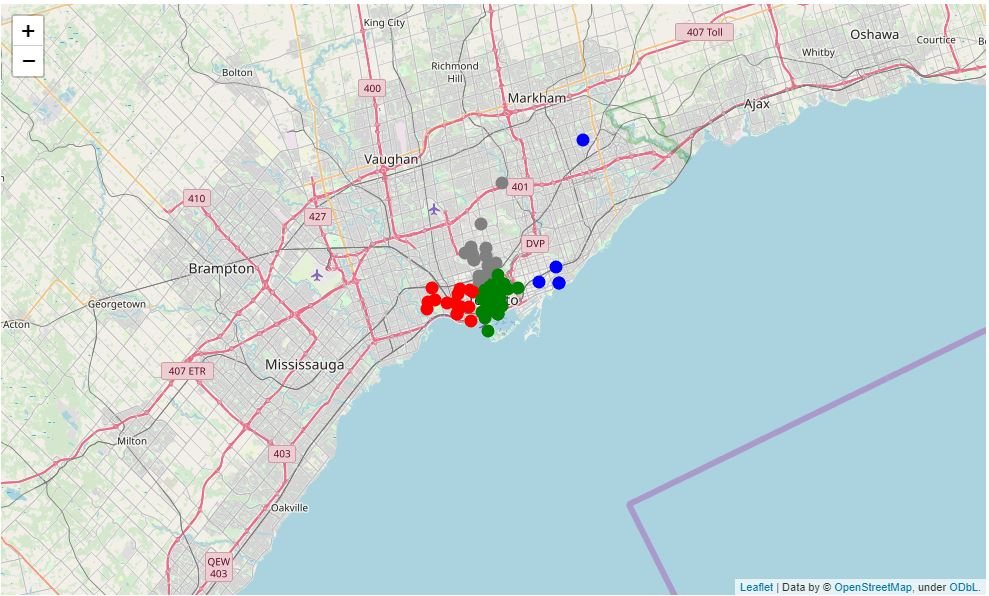

In [28]:
Image(filename='C:/Users/akash/Desktop/GitUpdate/Clustered_Toronto_Neighbourhoods.jpg')